# Setup

In [1]:
# Packages -----------------------------------------------#

import os

# Data Analysis
import xarray as xr
import numpy as np
import pandas as pd
import metpy.calc as mpcalc
import matplotlib.dates as dates

# Plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.ndimage import gaussian_filter
from matplotlib.lines import Line2D

# Timing Processes
import time

# make sure the figures plot inline rather than at the end
%matplotlib inline

# Functions

In [2]:
def add_land(ax,bounds):
    res = '50m'
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    land = cfeature.NaturalEarthFeature('physical', 'land', res,
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])
    ax.add_feature(land,color='gray',zorder = 0)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution=res,zorder = 0)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    
    
def find_coast(arr):
    import itertools
    
    # create empty lists to add row and col info to
    rowind = []
    colind = []

    # create an array of indices
    rows = np.arange(arr.shape[0])
    cols = np.arange(arr.shape[1])

    # find if the sum of a block around a point is a nan (meaning one of the values at least must have been a nan)
    for row,col in itertools.product(rows,cols):
#         cond = (~np.isnan(arr[row,col])) & (np.isnan(np.sum(arr[max(0,row-1):min(arr.shape[0],row+2),max(0,col-1):min(arr.shape[1],col+2)])))
        rowcond = (np.isnan(np.sum(arr[max(0,row-1):min(arr.shape[0],row+2),col])))
        colcond = (np.isnan(np.sum(arr[row,max(0,col-1):min(arr.shape[1],col+2)])))

#         if  (~np.isnan(arr[row,col])) & cond):
        if  (~np.isnan(arr[row,col])) & (rowcond | colcond):
            rowind.append(rows[row].tolist())
            colind.append(cols[col].tolist())
    
    return np.array(rowind), np.array(colind)


def order_coast(loninds,latinds,sta_zero):
    # find based on radius
    zipped_lists = zip(loninds, latinds)
    sorted_pairs = sorted(zipped_lists, reverse=True)

    # sort by lon
    tuples = zip(*sorted_pairs)
    lon_list,lat_list  = [ list(tuple) for tuple in  tuples]

    pos = []
    curr_sta = []
    rem_sta = sorted_pairs
    for i in range(len(lon_list)):
#         print(i)
        if i == 0:
            curr_sta.append(sta_zero)
            rem_sta.remove(sta_zero) 
            prev_sta = sta_zero
        else:
            prev_sta = curr_sta[i-1]

        start_len = len(curr_sta)
        for j,(lo, la) in enumerate(rem_sta):
            next_sta = (rem_sta[j])
            
            diff = tuple(map(lambda l, k: l - k, curr_sta[i], next_sta))
            
            # check uplr first
            if(next_sta != prev_sta) & (all(np.abs(diff) == [0,1])) | (all(np.abs(diff) == [1,0])):
                curr_sta.append(next_sta)
                rem_sta.remove(next_sta) 
                break

            # then check diagonals
            elif (next_sta != prev_sta) & (all(np.abs(diff) == [1,1])):
                curr_sta.append(next_sta)
                rem_sta.remove(next_sta) 
                break
                
        if len(curr_sta) == start_len:
            print('No Next Station Found. Returning Previous Stations Only.')
            print(curr_sta[i],rem_sta)
            break
        
    sta_lonind, sta_latind  = map(np.array, zip(*curr_sta))
    
    return sta_lonind, sta_latind



# 0.25 Degree

No Next Station Found. Returning Previous Stations Only.
(44, 140) [(235, 102), (235, 80), (160, 117), (160, 116), (77, 170)]


<xarray.Dataset>
Dimensions:      (loc_list: 7, no_stations: 583)
Coordinates:
  * no_stations  (no_stations) float64 1.0 2.0 3.0 4.0 ... 581.0 582.0 583.0
  * loc_list     (loc_list) int64 0 89 210 300 390 500 582
Data variables:
    sta_loninds  (no_stations) int64 72 73 74 75 76 77 78 ... 48 48 47 46 45 44
    sta_latinds  (no_stations) int64 80 80 80 80 80 80 ... 142 141 141 140 140
    sta_lon      (no_stations) float64 58.12 58.38 58.62 ... 51.62 51.38 51.12
    sta_lat      (no_stations) float64 0.125 0.125 0.125 ... 15.38 15.12 15.12

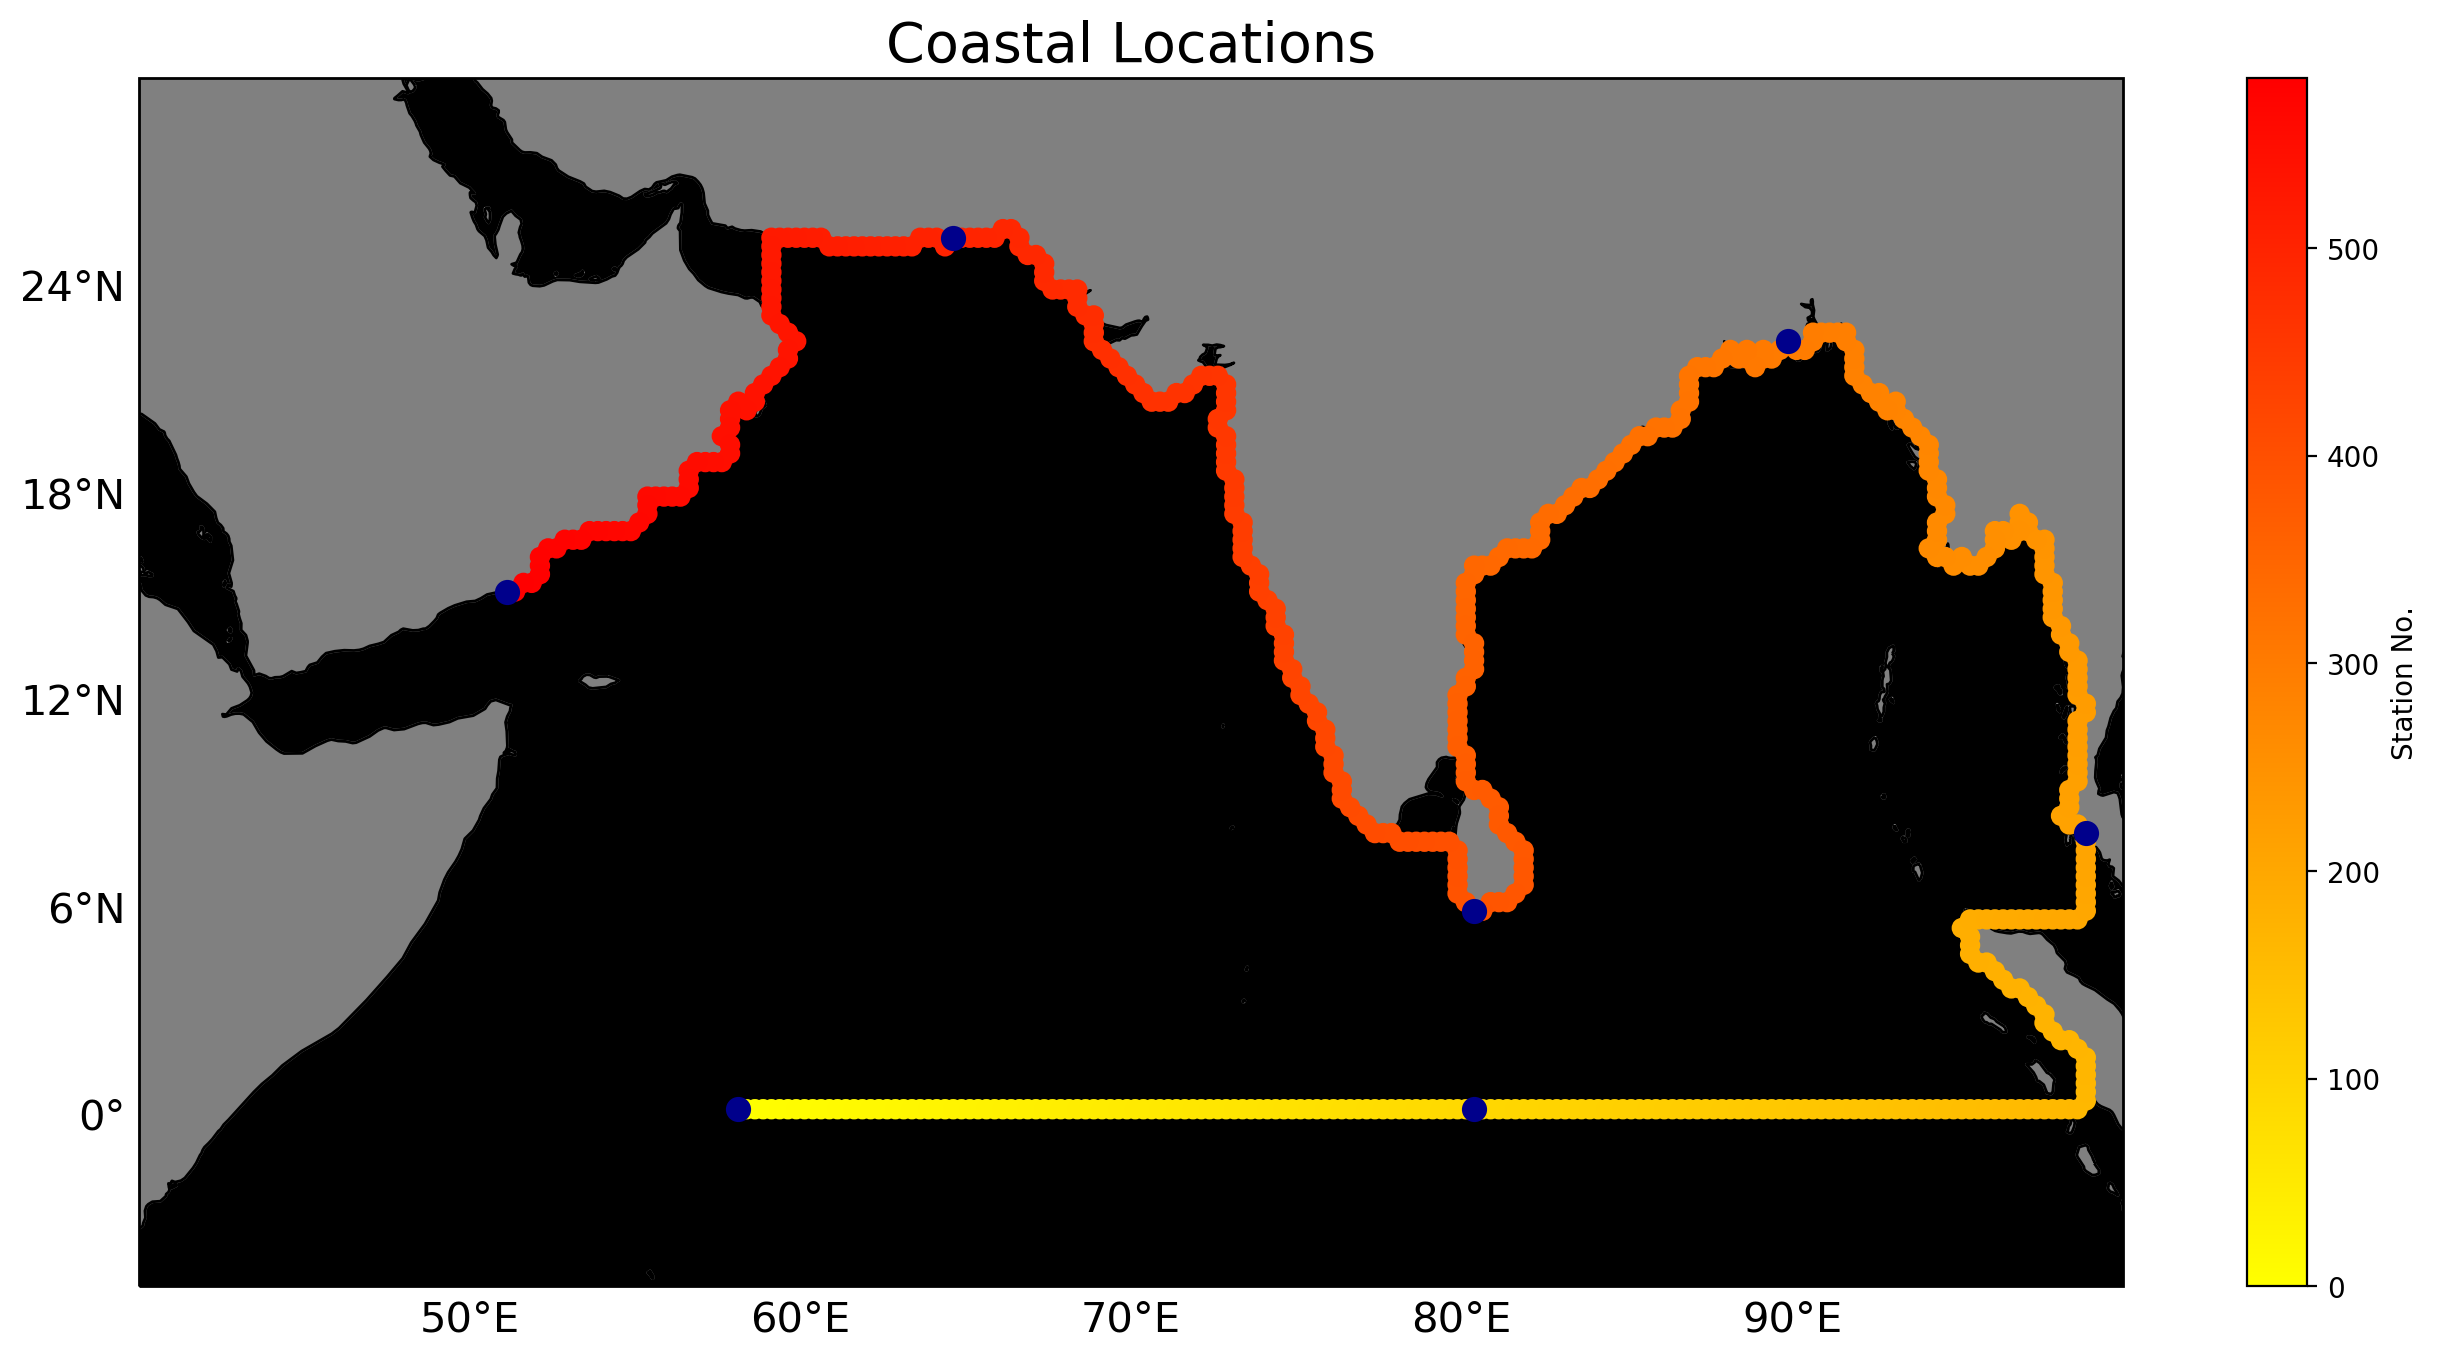

In [5]:
# get data from tigress
path = '../../data/SLA/'
# infn = 'all_adt_sla_global_twosat_phy_l4_vDT2018_daily_1994_2018_processed.nc'
# infn = 'all_adt_sla_global_twosat_phy_l4_vDT2018_daily_1994_2020_03_01_dtrnd.nc'
infn = 'sla_25km_processed.nc'

ds_SLA = xr.open_dataset(path + infn)

# Subset ------------------------------------------------#
# Create slice variables to subset domain before finding means
lat_slice = slice(-20, 30) # bounds inclusive
lon_slice = slice(40, 100) # bounds inclusive

# Get data, selecting lat/lon slice
daily_sla_dtrnd = ds_SLA['daily_sla'].sel(lat=lat_slice,lon=lon_slice)
mon_sla_mon_anom_dtrnd = ds_SLA['mon_sla_mon_anom'].sel(lat=lat_slice,lon=lon_slice)
sla_mon_clim_dtrnd = ds_SLA['sla_mon_clim'].sel(lat=lat_slice,lon=lon_slice)
lat = daily_sla_dtrnd.lat.values
lon = daily_sla_dtrnd.lon.values


# ------------------------------------------------------------#
# block out a few places that you don't want to include
# ------------------------------------------------------------#

mask = daily_sla_dtrnd[0,:,:]
xx,yy = np.meshgrid(lon,lat)
# set Gulfs to Nans
mask = mask.where(~((yy>22) & (xx<59)))
mask = mask.where(~((yy>10) & (xx<51)))

# AS inlets
mask = mask.where(~((yy>21.5) & (yy<23) & (xx>72) & (xx<73)))
mask = mask.where(~((yy>22.25) & (yy<23) & (xx>69) & (xx<70.5)))
mask = mask.where(~((yy>23.25) & (yy<24) & (xx>68.5) & (xx<70)))

# sri lanka are
mask = mask.where(~((yy>8) & (yy<10.5) & (xx>78) & (xx<80)))

# Sumatra area
mask = mask.where(~((yy>4.5) & (yy<5.5) & (xx>95.5) & (xx<100)))
mask = mask.where(~((yy>3) & (yy<5.5) & (xx>97.5) & (xx<100)))
mask = mask.where(~((yy>0) & (yy<10) & (xx>99) & (xx<100)))
mask = mask.where(~((yy>0) & (yy<2.5) & (xx>97) & (xx<98)),1)

# equator
mask = mask.where(~(yy<0))
# ------------------------------------------------------------#
# locate points along the BoB and AS
# ------------------------------------------------------------#

sta_latinds_unord, sta_loninds_unord = find_coast(np.array(mask))
# ------------------------------------------------------------#
# Remove Manually some other points
# ------------------------------------------------------------#

sta_latinds_unord = sta_latinds_unord[60:]
sta_loninds_unord = sta_loninds_unord[60:]

# AS
lons_from_sta = lon[sta_loninds_unord]
lats_from_sta = lat[sta_latinds_unord]

ind = ~((lons_from_sta <52) & (lats_from_sta < 15))
sta_latinds_unord = sta_latinds_unord[ind]
sta_loninds_unord = sta_loninds_unord[ind]

#BoB
lons_from_sta = lon[sta_loninds_unord]
lats_from_sta = lat[sta_latinds_unord]

ind = ~(lons_from_sta >99)
sta_latinds_unord = sta_latinds_unord[ind]
sta_loninds_unord = sta_loninds_unord[ind]

# ------------------------------------------------------------#
# Plot
# ------------------------------------------------------------#

# bounds = [40,100,-5,30]
    
# cmin = -0.2
# cmax = 0.2
# levels = np.linspace(cmin, cmax, 10)

# # Start figure
# fig = plt.figure(figsize=(16, 8))
# ax = plt.axes(projection=ccrs.PlateCarree())
# add_land(ax,bounds)
# # cf = ax.contourf(lon, lat,sla_mon_anom[0,:,:],levels = levels,cmap=plt.cm.PuOr_r, extend="both")
# plt.scatter(lon[sta_loninds_unord],lat[sta_latinds_unord],
#             s = 160,c=np.arange(len(sta_latinds_unord)),marker = '.',cmap =plt.cm.PiYG)
# plt.colorbar(label = 'Station No.')
# plt.title('Unordered Stations')

# ------------------------------------------------------------#
# put in the right order
# ------------------------------------------------------------#

#initial station
sta_zero = (sta_loninds_unord[0],sta_latinds_unord[0]) # 98.625, 10.375

#calculate
sta_loninds, sta_latinds =order_coast(sta_loninds_unord,sta_latinds_unord,sta_zero)

# ------------------------------------------------------------#
# identify first stations for EQ, BOB, and AS
# ------------------------------------------------------------#

EQ = 0
JA = 89
sBoB = 210
mBoB = 300
SL = 390
mAS = 500
eAS = 582
loc_list = [EQ,JA,sBoB,mBoB,SL,mAS,eAS]

# ------------------------------------------------------------#
# plot
# ------------------------------------------------------------#
cmin = -0.2
cmax = 0.2
levels = np.linspace(cmin, cmax, 10)

# Start figure
fig = plt.figure(figsize=(16, 8), dpi = 200)
ax = plt.axes(projection=ccrs.PlateCarree())
add_land(ax,bounds = [40,100,-5,30])
p =plt.scatter(lon[sta_loninds],lat[sta_latinds],
            s = 160,c=np.arange(len(sta_latinds)),marker = '.',cmap =plt.cm.autumn_r) 
plt.scatter(lon[sta_loninds[loc_list]],lat[sta_latinds[loc_list]],
            s = 260,c='darkblue',marker = '.')
plt.colorbar(p,label = 'Station No.')
plt.title('Coastal Locations', fontsize = 20)

# plt.savefig('../figures/stations-SLA-along-coast-0-25-degree.png', dpi=300, bbox_inches='tight')

no_stations =np.linspace(1,len(sta_loninds),len(sta_loninds))

# convert to xarray dataset
ds=xr.Dataset(coords={'no_stations': no_stations})

ds['sta_loninds'] = xr.DataArray(sta_loninds,dims = ['no_stations'],coords =[no_stations])
ds['sta_latinds'] = xr.DataArray(sta_latinds,dims = ['no_stations'],coords =[no_stations])
ds['sta_lon'] = xr.DataArray(lon[sta_loninds],dims = ['no_stations'],coords =[no_stations])
ds['sta_lat'] = xr.DataArray(lat[sta_latinds],dims = ['no_stations'],coords =[no_stations])
ds['loc_list'] = xr.DataArray(loc_list,dims = ['loc_list'],coords =[loc_list])

outfn = 'sla-coastlines-25km.nc'

# delete if already present
if os.path.isfile(outfn):
    os.remove(outfn)

ds.to_netcdf(outfn,mode='w',format = "NETCDF4")
ds

In [ ]:
del ds

# 1 degree

In [ ]:
# ------------------------------------------------------------#
# block out a few places that you don't want to include
# ------------------------------------------------------------#

mask = mon_sla_mon_anom_dtrnd[0,:,:]
xx,yy = np.meshgrid(lon,lat)
# set Gulfs to Nans
mask = np.where(~((yy>22) & (xx<60)),mask,np.nan)
mask = np.where(~((yy>10) & (xx<51)),mask,np.nan)

# AS inlets
mask = np.where(~((yy>21.5) & (yy<22) & (xx>72) & (xx<73)),mask,np.nan)
mask = np.where(~((yy>22.25) & (yy<22) & (xx>69) & (xx<70.5)),mask,np.nan)
mask = np.where(~((yy>23.25) & (yy<22) & (xx>69) & (xx<70)),mask,np.nan)

# sri lanka are
mask = np.where(~((yy>8) & (yy<10.5) & (xx>78) & (xx<80.5)),mask,np.nan)

# Sumatra area
mask = np.where(~((yy>4.5) & (yy<5.5) & (xx>95.5) & (xx<99)),mask,np.nan)
mask = np.where(~((yy>3) & (yy<5.5) & (xx>97.5) & (xx<101)),mask,np.nan)
mask = np.where(~((yy>-1) & (yy<12) & (xx>98) & (xx<102)),mask,np.nan)
mask = np.where(~((yy>11.5) & (yy<13) & (xx>98)),mask,np.nan)

# equator
mask = np.where(~(yy<0),mask,np.nan)
# ------------------------------------------------------------#
# locate points along the BoB and AS
# ------------------------------------------------------------#

sta_latinds_unord, sta_loninds_unord = find_coast(np.array(mask))

# ------------------------------------------------------------#
# Remove Manually some other points
# ------------------------------------------------------------#

sta_latinds_unord = sta_latinds_unord[17:]
sta_loninds_unord = sta_loninds_unord[17:]

# AS
lons_from_sta = lon[sta_loninds_unord]
lats_from_sta = lat[sta_latinds_unord]

ind = ~((lons_from_sta <52) & (lats_from_sta < 15))
sta_latinds_unord = sta_latinds_unord[ind]
sta_loninds_unord = sta_loninds_unord[ind]

#BoB
lons_from_sta = lon[sta_loninds_unord]
lats_from_sta = lat[sta_latinds_unord]

ind = ~(lons_from_sta >99)
sta_latinds_unord = sta_latinds_unord[ind]
sta_loninds_unord = sta_loninds_unord[ind]

# ------------------------------------------------------------#
# Plot
# ------------------------------------------------------------#

# bounds = [40,100,-5,30]

# cmin = -0.2
# cmax = 0.2
# levels = np.linspace(cmin, cmax, 10)

# # Start figure
# fig = plt.figure(figsize=(16, 8))
# ax = plt.axes(projection=ccrs.PlateCarree())
# add_land(ax,bounds)
# # cf = ax.contourf(lon, lat,sla_mon_anom[0,:,:],levels = levels,cmap=plt.cm.PuOr_r, extend="both")
# plt.scatter(lon[sta_loninds_unord],lat[sta_latinds_unord],
#             s = 160,c=np.arange(len(sta_latinds_unord)),marker = '.',cmap =plt.cm.PiYG)
# plt.colorbar(label = 'Station No.')
# plt.title('Unordered Stations')

# ------------------------------------------------------------#
# put in the right order
# ------------------------------------------------------------#

#initial station
sta_zero = (sta_loninds_unord[0],sta_latinds_unord[0]) # 98.625, 10.375

#calculate
sta_loninds, sta_latinds =order_coast(sta_loninds_unord,sta_latinds_unord,sta_zero)

# ------------------------------------------------------------#
# identify first stations for EQ, BOB, and AS
# ------------------------------------------------------------#

EQ = 0
JA = 20
sBoB = 47
mBoB = 65
SL = 87
mAS = 113
eAS = 129
loc_list = [EQ,JA,sBoB,mBoB,SL,mAS,eAS]

# ------------------------------------------------------------#
# plot
# ------------------------------------------------------------#
bounds = [40,100,-5,30]
    
cmin = -0.2
cmax = 0.2
levels = np.linspace(cmin, cmax, 10)

# Start figure
fig = plt.figure(figsize=(16, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
add_land(ax,bounds)
p =plt.scatter(lon[sta_loninds],lat[sta_latinds],
            s = 160,c=np.arange(len(sta_latinds)),marker = '.',cmap =plt.cm.PiYG) 
plt.scatter(lon[sta_loninds[loc_list]],lat[sta_latinds[loc_list]],
            s = 260,c='darkblue',marker = '.')
plt.colorbar(p,label = 'Station No.')
plt.title('Stations')

plt.savefig('../../figures/stations-SLA-along-coast-1-degree.png', dpi=300, bbox_inches='tight')

no_stations =np.linspace(1,len(sta_loninds),len(sta_loninds))

# convert to xarray dataset
ds=xr.Dataset(coords={'no_stations': no_stations})

ds['sta_loninds'] = xr.DataArray(sta_loninds,dims = ['no_stations'],coords =[no_stations])
ds['sta_latinds'] = xr.DataArray(sta_latinds,dims = ['no_stations'],coords =[no_stations])
ds['loc_list'] = xr.DataArray(loc_list,dims = ['loc_list'],coords =[loc_list])

outfn = 'SLA-coastlines-1-degree.nc'

# delete if already present
if os.path.isfile(outfn):
    os.remove(outfn)

ds.to_netcdf(outfn,mode='w',format = "NETCDF4")
ds